In [10]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import time
from duckietown.components.duckiebot import MotorsDriverComponent

from typing import Optional
from duckietown.components.duckiebot import WheelEncoderDriverComponent

import random
import copy

import torch

# TODO: change this to the name of your Duckiebot
VEHICLE_NAME: str = "yanniduck"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:

class DuckiebotDetection():
    """
    This is an example of a component that flips an image vertically.

    Args:
        axis: int       Axis along which the image is flipped. 0 = Vertical, 1 = Horizontal
    """

    def __init__(self):

        self.model = self.load_model()
        self.classes = self.model.names
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("\n\nDevice Used:",self.device)

    def infer(self, bgr):

        results = self.score_frame(bgr)
        bgr = self.plot_boxes(results, bgr)
        return results, bgr
    
    def load_model(self):
        """
        Loads Yolo5 model from pytorch hub.
        :return: Trained Pytorch model.
        """
        this_dir: str = os.path.abspath('')
        assets_dir: str = os.path.join(this_dir, "..", "..", "assets")
        model = torch.hub.load(os.path.join(assets_dir, "yolov5"), 'custom', path=os.path.join(assets_dir, "model/model.pt"), source='local') 
        return model

    def score_frame(self, frame):
        """
        Takes a single frame as input, and scores the frame using yolo5 model.
        :param frame: input frame in numpy/list/tuple format.
        :return: Labels and Coordinates of objects detected by model in the frame.
        """
        self.model.to(self.device)
        frame = [frame]
        results = self.model(frame)
     
        labels, cord = results.xyxyn[0][:, -1], results.xyxyn[0][:, :-1]
        return labels, cord

    def class_to_label(self, x):
        """
        For a given label value, return corresponding string label.
        :param x: numeric label
        :return: corresponding string label
        """
        return self.classes[int(x)]

    def plot_boxes(self, results, frame,  confidence_threshold = 0.2):
        """
        Takes a frame and its results as input, and plots the bounding boxes and label on to the frame.
        :param results: contains labels and coordinates predicted by model on the given frame.
        :param frame: Frame which has been scored.
        :return: Frame with bounding boxes and labels ploted on it.
        """
        labels, cord = results
        n = len(labels)
        x_shape, y_shape = frame.shape[1], frame.shape[0]
        for i in range(n):
            row = cord[i]
            if row[4] >= confidence_threshold:
                x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
                bgr = (0, 255, 0)
                cv2.rectangle(frame, (x1, y1), (x2, y2), bgr, 2)
                cv2.putText(frame, self.class_to_label(labels[i]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)

        return frame

    def results_to_bounding_boxes(self, results, frame, confidence_threshold = 0.2):
        labels, cord = results
        n = len(labels)
        x_shape, y_shape = frame.shape[1], frame.shape[0]

        bounding_boxes = []
        cropped_images = []
        for i in range(n):
            row = cord[i]
            if row[4] >= confidence_threshold:
                x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)

                # Calculate center of the rectangle
                center_x = (x1 + x2) / 2.0 / x_shape
                center_y = (y1 + y2) / 2.0 / y_shape

                area = abs(x1-x2) * abs(y1-y2)
                if area > 0.07:
                    bounding_box = [x1, y1, x2, y2, center_x, center_y]
                    bounding_boxes.append(bounding_box)
                    cropped_images.append(frame[y1:y2,x1:x2])

                



        return bounding_boxes,cropped_images

In [12]:
## Set up lane following in this cell

import numpy as np
from duckietown.types import BGRImage, Queue
from duckietown.components import Component
import os
from duckietown.types import CameraParameters

# TODO: change this to the name of your Duckiebot
VEHICLE_NAME: str = "yanniduck"

# TODO: change this to your duckiebot's camera parameters
CAMERA_PARAMETERS: CameraParameters = {
    "width": 640,
    "height": 480,
    "K": np.reshape(
        [
            295.79606866959824,
            0.0,
            321.2621599038631,
            0.0,
            299.5389048862878,
            241.73616515312332,
            0.0,
            0.0,
            1.0,
        ],
        (3, 3),
    ),
    "D": [
        -0.23543978771661125,
        0.03637781479419574,
        -0.0033069818601306755,
        -0.0012140708179525926,
        0.0,
    ],
    "P": np.reshape(
        [
            201.14027404785156,
            0.0,
            319.5586620845679,
            0.0,
            0.0,
            239.74398803710938,
            237.60151004037834,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
        ],
        (3, 4),
    ),
    "H": np.reshape(
        [
            8.56148231e-03,
            2.22480148e-01,
            4.24318934e-01,
            -5.67022044e-01,
            -1.13258040e-03,
            6.81113839e-04,
            5.80917161e-02,
            4.35079347e00,
            1.0,
        ],
        (3, 3),
    ),
}

from typing import List,Union,Tuple

state = "lanefollow"


class MasterComponent(Component[List[float], List[float]]) :
    """
    Componentn that starts and stops lane following

    Args:
        axis: int       Axis along which the image is flipped. 0 = Vertical, 1 = Horizontal
    """

    def __init__(self):
        super(MasterComponent, self).__init__()
        self.in_pwml_pwmr: Queue[int] = Queue()
        self.out_pwml_pwmr: Queue[int] = Queue()


    def worker(self):

        t_0 = time.time()
        while not self.is_shutdown:
            #if time.time() - t_0 < 3 and time.time() - t_0 > 0:
            if state == "lanefollow":
                on = True
                self.out_pwml_pwmr.put(self.in_pwml_pwmr.get())
            #elif on:
            else:
                navigate_intersection(left_wheel_encoder,right_wheel_encoder,motors, direcc, leds, patterns)

                # self.out_pwml_pwmr.put((0,0))
                # t_0 = time.time()+3
                # on = False

# Sensor - Camera
from duckietown.components.duckiebot import CameraDriverComponent
camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME)
from duckietown.components.lane_following import ImageCropComponent
image_crop: ImageCropComponent = ImageCropComponent(parameters=CAMERA_PARAMETERS)
from duckietown.components.lane_following import LineDetectorComponent
line_detector: LineDetectorComponent = LineDetectorComponent()
from duckietown.components.lane_following import LaneFilterComponent
lane_filter: LaneFilterComponent = LaneFilterComponent(camera_parameters=CAMERA_PARAMETERS)
from duckietown.components.lane_following import LaneControllerComponent
lane_controller: LaneControllerComponent = LaneControllerComponent()
from duckietown.components.lane_following import InverseKinematicsComponent
inverse_kinematics: InverseKinematicsComponent = InverseKinematicsComponent()
from duckietown.components.lane_following import PWMComponent
pwm: PWMComponent = PWMComponent()
from duckietown.components.duckiebot import MotorsDriverComponent
lane_motors: MotorsDriverComponent = MotorsDriverComponent(vehicle_name=VEHICLE_NAME)

image_crop.in_bgr.wants(camera.out_bgr)
line_detector.in_bgr.wants(image_crop.out_bgr)
lane_filter.in_lines.wants(line_detector.out_lines)
lane_filter.in_command_time.wants(lane_motors.out_command_time)
lane_filter.in_v_omega.wants(lane_controller.out_v_omega)
lane_controller.in_d_phi.wants(lane_filter.out_d_phi)
inverse_kinematics.in_v_omega.wants(lane_controller.out_v_omega)
pwm.in_wl_wr.wants(inverse_kinematics.out_wl_wr)
lane_motors.in_pwml_pwmr.wants(pwm.out_pwml_pwmr)

from duckietown.components.rendering import ImageRendererComponent
from duckietown.components.rendering import intersection_ImageRendererComponent

# define components
segments: ImageRendererComponent = ImageRendererComponent()
belief: ImageRendererComponent = ImageRendererComponent()

# connect components
segments.in_image.wants(lane_filter.out_segments_image)
belief.in_image.wants(lane_filter.out_belief_image)

import time
from typing import List

from duckietown.components.base import Component
from duckietown.system import System


# list of components to run
all_lane_follow_components: List[Component] = [
    camera,
    image_crop,
    line_detector,
    lane_filter,
    lane_controller,
    inverse_kinematics,
    pwm,
    lane_motors,

]# create system






Using ROS...
Using ROS...


In [13]:
def PIDController(baseline_left_pwm : float, lr_ref: float, lr_act: float, prev_e_y: float, prev_int_lr: float, delta_t: float):
    kp = 0.6
    kd = 0
    ki = 0.4

    e = (lr_ref - lr_act)

    e_int = prev_int_lr + e * delta_t
    e_int = max(min(e_int,2),-2)

    edot = (e-prev_e_y) / delta_t

    left_pwm = baseline_left_pwm + kp*e + ki*e_int + kd*edot
    
    return left_pwm, e, e_int

def pose_estimation(R,baseline ,x_prev,y_prev,theta_prev,delta_phi_left,delta_phi_right):

    x_curr = x_prev + R*(delta_phi_left+delta_phi_right)*np.cos(theta_prev)/2
    y_curr = y_prev + R*(delta_phi_left+delta_phi_right)*np.sin(theta_prev)/2
    theta_curr = theta_prev + R*(delta_phi_right-delta_phi_left)/(baseline)


    return x_curr, y_curr, theta_curr



In [14]:
#def navigate_intersection(lwe, rwe, mot, directions, leds, patterns):
def navigate_intersection(lwe, rwe, mot, act, leds, patterns):

    wheel_r = 0.0318
    wheel_base = 0.035
    dl=0
    dr=0
    ##############
    # 0 = straight
    # 1 = right
    # 2 = left
    ##############


    ########## AFTER DETECTING AN INTERSECTION:
    action = act
    # if len(directions)==0:
    #     action = 0
    # else:
    #     action = random.choice(directions)

    if action == 0: #drive straight
        ref_lr_ratio = 1.02
        baseline_right = 0.15
        #dur = 2.5
    if action == 1: #turn right
        ref_lr_ratio = 1.85 # defines turn radius
        baseline_right = 0.05 # defines speed
    if action == 2: #turn left
        ref_lr_ratio = 0.78
        baseline_right = 0.28
    baseline_left = ref_lr_ratio * baseline_right

    #leds.in_pattern.put(patterns[action])
    leds.in_pattern.put(patterns[4])

    def check_complete(act, ti, tt, th):
        if act== 0:
            if tt-ti>3.5:
                return True
        elif act == 1:
            if th<-75:
                return True
        elif act == 2:
            if th>75:
                return True
        return False

    mot.stop()
    mot.reset()
    mot.start()
    
    init_ticks_l = lwe.out_ticks.get()
    init_ticks_r = rwe.out_ticks.get()

    prev_e = 0
    prev_int = 0

    x_curr,y_curr,theta_curr = 0,0,0

    right_pwm = baseline_right
    start_time = time.time()
    t = start_time
    mot.in_pwml_pwmr.put((baseline_left,baseline_right))

    time.sleep(0.05)
    while not check_complete(action, start_time, t, theta_curr):
        #maybe add a sleep here
        time.sleep(0.001)

        dl = lwe.out_ticks.get()-init_ticks_l
        dr = rwe.out_ticks.get()-init_ticks_r
        x_curr,y_curr,theta_curr = pose_estimation(wheel_r,wheel_base,0,0,0,dl,dr)

        if dr !=0:
            lr_ratio = dl/dr
        else:
            lr_ratio = ref_lr_ratio

        delta_t = time.time()-t
        t = time.time()
        left_pwm, prev_e, prev_int = PIDController(baseline_left, ref_lr_ratio, lr_ratio, prev_e, prev_int, delta_t)

        mot.in_pwml_pwmr.put((left_pwm, right_pwm))


    state = "lanefollow"




In [15]:
import cv2
import matplotlib.pyplot as plt


def intersection_stop_func(image_orig):

    h,w,c = image_orig.shape

    imgbgr = image_orig

    imgrgb = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)

    # Convert the image to HSV for any color-based filtering
    imghsv = cv2.cvtColor(imgbgr , cv2.COLOR_BGR2HSV)

    # Most of our operations will be performed on the grayscale version
    img = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2GRAY)

    sigma = 5

    # horizont mask
    imghsv[:150, :, :] = 255

    red_lower_hsv1 = np.array([0, 80, 100])         # CHANGE ME
    red_upper_hsv1 = np.array([10, 255, 255])   # CHANGE ME

    red_lower_hsv2 = np.array([160, 80, 100])         # CHANGE ME
    red_upper_hsv2 = np.array([180, 255, 255])   # CHANGE ME


    mask_red1 = cv2.inRange(imghsv, red_lower_hsv1, red_upper_hsv1)
    mask_red2 = cv2.inRange(imghsv, red_lower_hsv2, red_upper_hsv2)

    mask_red = cv2.bitwise_or(mask_red1, mask_red2)

    gaussian_filter = cv2.GaussianBlur(mask_red,(0,0), sigma)
    mask_intersection = cv2.inRange(gaussian_filter, 50 , 255)

    #contours, _ = cv2.findContours(mask_intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask_intersection)
    red_obj = sorted(stats, key=lambda x: x[4], reverse=True)

    area_tot = h*w
 

    intersections = []
    directions = [False, False, False]
    red_lines = 0
    stop = False
    for i in range(1, min(num_labels,5)):
        area = stats[i][4]
        y_max = stats[i][2] + stats[i][3]

        if (area > area_tot/20) and (y_max > 400):
            stop = True
        elif area > area_tot/1000:


            intersections.append(stats[i])

            
    if stop:

        
        sorted_intersections = sorted(intersections, key=lambda x: x[0])#, reverse=True)
        for i in range(min(len(sorted_intersections),4)):
            x_min = sorted_intersections[i][0]
            width = sorted_intersections[i][2]
            height = sorted_intersections[i][3]
            # if (x_min < w/2) and (width/height > 2.5):
            #     directions[1] = True #straight
            # elif x_min < w/5:
            #     directions[0] = True #left
            # elif x_min > w/3:
            #     directions[2] = True #right
            if (x_min < w/2) and (width/height > 2.5):
                directions[0] = True #straight
            elif x_min < w/5:
                directions[2] = True #left
            elif x_min > w/3:
                directions[1] = True #right


    return mask_intersection, stop, directions

def adjust_duckiebot(mask):
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize the list to store angles
    angles = []

    # Loop over the contours
    for contour in contours:
        # Fit a rotated rectangle to the contour
        rect = cv2.minAreaRect(contour)

        # Extract the angle from the rotated rectangle
        angle = rect[2]

        # Append the angle to the list
        angles.append(angle)

    # If there are no contours, return None
    if not angles:
        return None

    # Find the index of the bottommost rectangle
    bottommost_index = np.argmax([cv2.boundingRect(cnt)[1] for cnt in contours])

    # Return the angle of the bottommost rectangle

    ang = angles[bottommost_index]

    if ang>45:
        ang = ang-90
    return ang


In [16]:
from itertools import chain


default_parameters: dict = {
    "minThreshold": 5,
    "maxThreshold": 75,
    "thresholdStep": 10,

    # Filter by Area.
    "filterByArea": True,
    "minArea": (8 ** 2) * 3.14,    # min 8 pixels diameter
    "maxArea": (64 ** 2) * 3.14,   # max 64 pixels diameter

    # Filter by Circularity
    "filterByCircularity": True,
    "minCircularity": 0.7,

    # Filter by Convexity
    "filterByConvexity": True,
    "minConvexity": 0.8,

    # Filter by Inertia
    "filterByInertia": False,
    "minInertiaRatio": 0.05,
}



def extract_hsv(_bgr: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    _hsv = cv2.cvtColor(_bgr, cv2.COLOR_BGR2HSV)
    _h = _hsv[:,:,0]
    _s = _hsv[:,:,1]
    _v = _hsv[:,:,2]
    return _h, _s, _v


def detect_blobs(_bgr: np.ndarray, **_params) -> Tuple[cv2.KeyPoint, ...]:
    # create new configuration that extends the default
    _cfg = cv2.SimpleBlobDetector_Params()
    for _k, _v in chain(default_parameters.items(), _params.items()):
        setattr(_cfg, _k, _v)
    # create detector
    _detector = cv2.SimpleBlobDetector.create(_cfg)
    # find blobs
    _keypoints = _detector.detect(_bgr)
    print(f"Found {len(_keypoints)} blobs")
    return _keypoints

# Function to check if a color is within a specified range
def is_color_within_range(color, target_color, tolerance=30):
    lower_bound = np.array([c - tolerance for c in target_color])
    upper_bound = np.array([c + tolerance for c in target_color])
    return np.all(color >= lower_bound) and np.all(color <= upper_bound)

green_range = ([32, 20, 40], [80, 255, 255])
purple_range = ([120, 50, 50], [160, 255, 255])
blue_range = ([90, 50, 50], [120, 255, 255])
red_range = ([0, 50, 50], [30, 255, 255])


def is_color_in_range(color, color_range):
    lower_bound = np.array(color_range[0], dtype=np.uint8)
    upper_bound = np.array(color_range[1], dtype=np.uint8)
    color_np = np.array(color, dtype=np.uint8)

    mask = cv2.inRange(color_np, lower_bound, upper_bound)
    result = cv2.bitwise_and(color_np, color_np, mask=mask)

    return np.array_equal(color_np, result)

def draw_blobs(_bgr: np.ndarray, _blobs: Tuple[cv2.KeyPoint, ...]) -> np.ndarray:
    # draw blobs on the original image
    _bgr1 = copy.deepcopy(_bgr)
    for kp in _blobs:
        _bgr1 = cv2.circle(_bgr1, tuple(map(int, kp.pt)), int(kp.size), (0, 255, 0), 3)
    return _bgr1


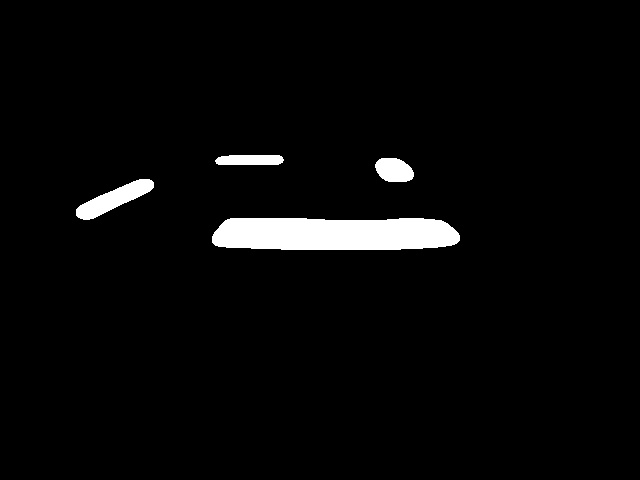

YOLOv5 🚀 2023-12-17 Python-3.8.10 torch-2.1.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
Adding AutoShape... 


Using ROS...
Using ROS...
Using ROS...
Using ROS...


Device Used: cpu


KeyboardInterrupt: 

In [17]:
from duckietown.components.duckiebot import CameraDriverComponent
from duckietown.components.rendering import intersection_ImageRendererComponent
# from intersection_stop import intersection_stop_func, adjust_duckiebot
from duckietown.components.duckiebot import LEDsPattern, LEDsDriverComponent
from typing import List,Union,Tuple
import math

# camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME)

renderer: intersection_ImageRendererComponent = intersection_ImageRendererComponent()
renderer.in_image.wants(camera.out_bgr)

led_renderer: ImageRendererComponent = intersection_ImageRendererComponent()


left_wheel_encoder: WheelEncoderDriverComponent = WheelEncoderDriverComponent(vehicle_name=VEHICLE_NAME, side="left")
right_wheel_encoder: WheelEncoderDriverComponent = WheelEncoderDriverComponent(vehicle_name=VEHICLE_NAME, side="right")

left_wheel_encoder.start()
right_wheel_encoder.start()

from duckietown.components.duckiebot import LEDsPattern, LEDsDriverComponent

leds: LEDsDriverComponent = LEDsDriverComponent(vehicle_name=VEHICLE_NAME)
leds.start()

motors: MotorsDriverComponent = MotorsDriverComponent(vehicle_name=VEHICLE_NAME)
motors.start()

# camera.start()
renderer.start()
led_renderer.start()



################################# Defining LED Colors
r,g,b=0,0,1
# define new pattern
intensity: float = 0.4
straight_pattern: LEDsPattern = LEDsPattern(
    front_left=(r, g, b, intensity),
    front_right=(r, g, b, intensity),
    rear_right=(r, g, b, intensity),
    rear_left=(r, g, b, intensity),
)

r,g,b=0,0.9,0
# define new pattern
intensity: float = 0.4
right_pattern: LEDsPattern = LEDsPattern(
    front_left=(r, g, b, intensity),
    front_right=(r, g, b, intensity),
    rear_right=(r, g, b, intensity),
    rear_left=(r, g, b, intensity),
)

# define new pattern
r,g,b=0.9,0,0
intensity: float = 0.4
left_pattern: LEDsPattern = LEDsPattern(
    front_left=(r, g, b, intensity),
    front_right=(r, g, b, intensity),
    rear_right=(r, g, b, intensity),
    rear_left=(r, g, b, intensity),
)

r,g,b=1,1,1
intensity: float = 0.4
white: LEDsPattern = LEDsPattern(
    front_left=(r, g, b, intensity),
    front_right=(r, g, b, intensity),
    rear_right=(r, g, b, intensity),
    rear_left=(r, g, b, intensity),
)

r,g,b=1,0,1
intensity: float = 0.4
purple: LEDsPattern = LEDsPattern(
    front_left=(r, g, b, intensity),
    front_right=(r, g, b, intensity),
    rear_right=(r, g, b, intensity),
    rear_left=(r, g, b, intensity),
)
patterns = [straight_pattern,right_pattern,left_pattern, white, purple]
####################################################################################

duckiebot_detection = DuckiebotDetection()

t = time.time()

for component in all_lane_follow_components:
    component.start()

# ind = 0
# actions = [2,1,0,1]
while True:
    #motors.in_pwml_pwmr.put((0.15,0.15))
    mask,stopp,direc = intersection_stop_func(camera.out_bgr.get())
    leds.in_pattern.put(white)

    if stopp:
        lane_motors.stop()

        angle = adjust_duckiebot(mask)
        t0 = time.time()
        while abs(angle)>3 and time.time()-t0<1:
            #print(angle)
            if angle>0:
                motors.in_pwml_pwmr.put((0.07,0))
            else:
                motors.in_pwml_pwmr.put((0,0.07))
            angle = adjust_duckiebot(mask)
            mask,stopp,direc = intersection_stop_func(camera.out_bgr.get())


        ### stop at red line
        motors.in_pwml_pwmr.put((0,0))
        time.sleep(0.1)

        ### move up to red line
        motors.in_pwml_pwmr.put((0.2,0.19))
        time.sleep(0.7)
        
        ### stop at red line
        motors.in_pwml_pwmr.put((0,0))
        motors.in_pwml_pwmr.put((0,0))
        time.sleep(0.05)
        motors.in_pwml_pwmr.put((0,0))
        time.sleep(0.05)

        direcc = [index for index, value in enumerate(direc) if value]
        if len(direcc)<1:
            action = 0
        else:
            action = random.choice(direcc)
        leds.in_pattern.put(patterns[action])
        time.sleep(1)


        right_bot = True
        moving_bot = True
        
        while right_bot:# or moving_bot:
        #while right_bot:
            # results, bgr = duckiebot_detection.infer(camera.out_bgr.get())
            
            # bounding_box_list, cropped_images_list = duckiebot_detection.results_to_bounding_boxes(results, bgr, confidence_threshold=0.3)

            # left_bot = []
            # center_bot = []
            # right_bot = []

            # for box in bounding_box_list:
            #     if box[4] < 1/7:
            #         left_bot.append(box)
            #     elif box[4] < 4/7:
            #         center_bot.append(box)
            #     else:
            #         right_bot.append(box)

            # for img in cropped_images_list:
            #     _, s, _ = extract_hsv(img)
            #     blobs: Tuple[cv2.KeyPoint, ...] = detect_blobs(
            #         s,
            #         # # ---- generic
            #         #minThreshold=10,
            #         # maxThreshold=75,
            #         # thresholdStep=10,
            #         # # ---- filter by area
            #         # filterByArea=True,
            #         # minArea=(8 ** 2) * 3.14,
            #         # maxArea=(64 ** 2) * 3.14,
            #         # # ---- filter by circularity
            #         # filterByCircularity=True,
            #         # minCircularity=0.7,
            #         # # ---- filter by convexity
            #         filterByConvexity=True,
            #         minConvexity=0.8,
            #         # # ---- filter by inertia
            #         # filterByInertia=False,
            #         # minInertiaRatio=0.05,
            #     )

            #     assigned_color = ""
            #     if blobs:
            #         biggest_blob = max(blobs, key=lambda x: x.size)

            #         x,y = int(biggest_blob.pt[0]), int(biggest_blob.pt[1])
            #         color = img[x,y]

            #         # Check if the color is within the defined range for each potential color
            #         if is_color_within_range(color, green_range):
            #             assigned_color = "Green"
            #         # elif is_color_within_range(color, purple_range[0], tolerance=30):
            #         #     assigned_color = "Purple"
            #         # elif is_color_within_range(color, blue_range[0], tolerance=30):
            #         #     assigned_color = "Blue"
            #         # elif is_color_within_range(color, red_range[0], tolerance=30):
            #         #     assigned_color = "Red"
            #         else:
            #             assigned_color = "Unknown"

            #     if assigned_color == "Green":
            #         moving_bot = True
            #     else:
            #         moving_bot = False
            #     led_renderer.in_image.put(draw_blobs(img,blobs))
                        

                        
                        
            if not right_bot: #and not moving_bot:
            #if not right_bot and not moving_bot:
                time.sleep(3)

                ### choose direction, and execute action

                #direcc = [actions[ind]]
                #navigate_intersection(left_wheel_encoder,right_wheel_encoder,motors, direcc, leds, patterns)
                navigate_intersection(left_wheel_encoder,right_wheel_encoder,motors, action, leds, patterns)

                stopp = False
                #ind = ind + 1
                
                ### restart lane following
                lane_motors.reset()
                lane_motors.start()



camera.stop()
renderer.stop()
motors.stop()
left_wheel_encoder.stop()
right_wheel_encoder.stop()
 


#navigate_intersection()

In [18]:
for component in all_lane_follow_components:
    component.stop()
    
camera.stop()
renderer.stop()
motors.stop()
left_wheel_encoder.stop()
right_wheel_encoder.stop()
leds.stop()